In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# coding=utf-8

import time

# refresca de lo importado cada vez que se hace ejecución
# %load_ext autoreload
# %autoreload 2

path= './data/'

# Graficación, funciones

In [2]:
def darstellungNurZwei(T, Meas2, sav= None):
    '''
    T: times vector
    Meas2: Both channels 2D array
    sav: plot filename (eps)
    '''
        
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
    fig.set_size_inches(10,8)
    fig.subplots_adjust(hspace=0.000)

    ax0.plot(T, Meas2[0,:], 'y')
    # Make the y-axis label and tick labels match the line color.
    ax0.set_ylabel('ch 1 [V]', color='y')
    ax0.grid(True)

    ax1.plot(T, Meas2[1,:], 'c')
    ax1.set_ylabel('ch 2 [V]', color='c')
    ax1.set_xlabel('tiempo [s]')
    ax1.grid(True)
    
    if (sav):
        plt.savefig('./data/plots/'+ sav+ '.eps')
    else:
        plt.show()

In [3]:
# lee archivo npy en la ruta datei y grafica cada medición
def dateiDarstellung(datei, sav= None):
    '''
    str -> ()
    
    De un archivo npy grafica cada medición (índice), ambos canales.
    '''
    lu= np.load(datei)
    zeit= lu[0]
    messungenZahl= lu.shape[0]
    for i in range(1, messungenZahl, 2):
        ix= int((i-1)/2)
        print('medición = '+ str(ix), ', índiceCH1= '+ str(i))
        Meas2= np.vstack([lu[i], lu[i+1]])
        if (sav):
            savi= sav+ str(i)
            darstellungNurZwei(zeit, Meas2, savi)
        else:
            darstellungNurZwei(zeit, Meas2)

# Risetime, funciones

In [4]:
def baseAcq(acqFile, prop=0.25):
    '''
    (array, float) -> array
    
    De la primer fracción prop de ambos canales de todas las adquisiciones en acqFile,
    obtiene el promedio y dispersión que se asume como nivel de base
    grProm[0]: promedio ch1, grProm[1]: promedio ch2,
    grProm[2]: desviación estandard ch1, grProm[3]: desviación estandard ch2
    '''
    messungenZahl= acqFile.shape
    erstePunkten= int(messungenZahl[1]* prop)
    prom= np.zeros([int((messungenZahl[0]- 1)/ 2), 4])
    for i in range(1, messungenZahl[0], 2):
        ix= int((i-1)/2)
        ch1Erste= acqFile[i][0:erstePunkten-1]
        ch2Erste= acqFile[i+1][0:erstePunkten-1]
        prom[ix,0]= ch1Erste.mean()
        prom[ix,1]= ch2Erste.mean()
        prom[ix,2]= ch1Erste.std()
        prom[ix,3]= ch2Erste.std()
    return prom

In [5]:
def baseMeas2(Meas2, messungenZahl, prop=0.25):
    '''
    (array, array, float) -> array
    
    De la primer fracción prop de ambos canales en Meas2,
    obtiene el promedio y dispersión que se asume como nivel de base
    grProm[0]: promedio ch1, grProm[1]: promedio ch2,
    grProm[2]: desviación estandard ch1, grProm[3]: desviación estandard ch2
    '''
    erstePunkten= int(messungenZahl[1]* prop)
    ch1Erste= Meas2[0][0:erstePunkten-1]
    ch2Erste= Meas2[1][0:erstePunkten-1]
    return np.array([ch1Erste.mean(), ch2Erste.mean(), ch1Erste.std(), ch2Erste.std() ] )

In [6]:
def tauCeti2(T, Meas2, messungenZahl, prop):
    '''
    Calcula índices risetime como tiempo entre 10% y 90% de excursión entre nivel de base y máximo
   
    Meas2: array (2,:) con Meas2[0] canal 1, Meas2[0] canal 2, producto de np.vstack
    baseMeas2: base(Meas2)
    '''
    # niveles base
    bMeas2= baseMeas2(Meas2, messungenZahl, prop)

    # índice máximo
    maxIx= (Meas2[0].argmax(), Meas2[1].argmax() )

    # máximo promediado cercano
    rangoCercano= 20 # tres lecturas a izq y derecha
    maxCH1= (Meas2[0][maxIx[0]- rangoCercano: maxIx[0]+ rangoCercano]).mean()
    maxCH2= (Meas2[1][maxIx[1]- rangoCercano: maxIx[1]+ rangoCercano]).mean()

    # diferencia máximo- base
    # maxCH1= Meas2[0][maxIx[0]] # max CH1
    # maxCH2= Meas2[1][maxIx[1]] # max CH2
    # deltaV= np.array([Meas2[0][maxIx[0]]- bMeas2[0], Meas2[1][maxIx[1]]- bMeas2[1]])
    deltaV= np.array([maxCH1- bMeas2[0],maxCH2- bMeas2[1]]) # usa promediado cercano

    # Diferencias de potencial para 10%, 90% de excursión
    v10= bMeas2[0:2]+ 0.1* deltaV
    v90= bMeas2[0:2]+ 0.9* deltaV

    # Índices para primer potencial del pulso que exceda 10%, y último por debajo 90% 
    ixTau= np.array([0, 0, maxIx[0], maxIx[1]])
    while (Meas2[0,ixTau[0]]< v10[0]):
        ixTau[0]+= 1
    while (Meas2[1,ixTau[1]]< v10[1]):
        ixTau[1]+= 1
    while (Meas2[0,ixTau[2]]> v90[0]):
        ixTau[2]-= 1
    while (Meas2[1,ixTau[3]]> v90[1]):
        ixTau[3]-= 1
        
    return np.array([T[ixTau[2]]- T[ixTau[0]], T[ixTau[3]]- T[ixTau[1]] ])

In [7]:
def tauAMC2(acqData, prop= 0.25):
    '''
    Genera vectores de promedio y dispersión del risetime de ambos canales a partir de archivo acq*
    
    archivo: acq* 
    prop= porcentaje inferior del canal a promediar para obtener nivel de base     
    '''
    messungenZahl= acqData.shape

    # tiempo
    T= acqData[0]

    tauAMC= np.empty([int((messungenZahl[0]- 1)/ 2), 1])
    for i in range(1, messungenZahl[0], 2):
        Meas2= np.array([acqData[i], acqData[i+1] ] )
        ix= int((i-1)/2)
        tauAMC[ix]= tauCeti2(T, Meas2, messungenZahl, prop)[1]
    return tauAMC

In [8]:
def tauAMCz(npzData, prop= 0.25):
    '''
    Vectores risetime canal AMC de archivo acq comprimido
    
    npzData= numpy.lib.npyio.NpzFile
    prop= porcentaje inferior del canal a promediar para obtener nivel de base     
    '''
    FLUC= npzData['ch1']
    AMC= npzData['ch2']

    messungenZahl= AMC.shape

    # tiempo
    T= npzData['zeit']

    tauAMC= np.empty([messungenZahl[0], 1])
    for i in range(messungenZahl[0]):
        Meas2= np.array([FLUC[i], AMC[i] ] )
        tauAMC[i]= tauCeti2(T, Meas2, messungenZahl, prop)[1]
    return tauAMC

In [9]:
def desvioEstandardCuasiNoSesgado(datos):
    '''
    Estimador cuasi no sesgado de la desviación estandar.
    https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation
    '''
    media= np.mean(datos)
    suma=0
    for i in datos:
        aux= (datos[i]- media)
        suma+= aux**2
    desv= np.sqrt(suma/( np.size(datos)- 1.5) ) 
    return desv

In [10]:
def errorEstandard(datos):
    '''
    Estimador de la desviación estandar del promedio.
    Usa la desviación estandar de la población y la divide por la raíz del número de elementos en la población.
    https://en.wikipedia.org/wiki/Standard_error
    '''
    return desvioEstandardCuasiNoSesgado(datos)/ np.sqrt(np.size(datos))

# Cambio composición

In [11]:
conv= 98066.5* (1/101325) # presión absoluta atm/(kgf/cm2)= (Pa/(kgf/cm2))* (atm/Pa)
pAtm= 1/conv # [kgf/cm²] (abs)

## Lo que hay

In [12]:
pActual= 3.005 # [kgf/cm²] (rel)
pN2Actual= 0.02  # [kgf/cm²] (abs)
pArActual= pActual- pN2Actual+ pAtm  # [kgf/cm²] (abs)

riquezaActual= pN2Actual/pArActual # [P_{N_2}/P_Ar] (abs)
# Tres cámaras: topo superior, topo inferior (incluye tubo al detector), detector (después de válvula propia)
pAbierta= 2.6825 # [kgf/cm²] (rel)

## Objetivo

In [13]:
pObjetivo= 3.005 # [kgf/cm²] (rel)
pObjetivo+= pAtm # [kgf/cm²] (abs)
riquezaObjetivo= 0.01
pN2Objetivo= pArActual* riquezaObjetivo
pN2Llenar= pN2Objetivo- pAbierta* riquezaActual
pArObjetivo= pObjetivo- (pN2Llenar+ pAbierta* riquezaActual)
riquezaObjetivoVerificacion= (pN2Llenar+ pAbierta* riquezaActual)/ pArObjetivo
pObjetivoVerificacion= pArObjetivo+ pN2Objetivo
pN2Llenar, riquezaObjetivoVerificacion, pObjetivoVerificacion-pAtm

(0.02683061620845379, 0.010050480356344356, 3.005)

In [14]:
0.025-pN2Llenar

-0.0018306162084537891

In [15]:
pAbierta+ pN2Llenar

2.709330616208454

Llene desde pAbierta hasta $2.710\mathrm{\frac{kgf}{cm^2}}$ con $N_2$ y completé con $Ar$ hasta $3.005\mathrm{\frac{kgf}{cm^2}}$

In [16]:
pN2Final= pAbierta* riquezaActual+ (2.71-pAbierta)
pArFinal= 3.005- pN2Final
pArFinal+= pAtm
riquezaFinal= pN2Final/ pArFinal
pN2Final, pArFinal, riquezaFinal, pArFinal+pN2Final

(0.04085165831954493,
 3.9973757944803405,
 0.010219619175148293,
 4.038227452799886)

# Adquisiciones

###### acq150605z01: CFP-35, 2560 pulsos, $P=3.005\mathrm{\frac{kgf}{cm^2}}$ (relativa), $\mathrm{N_2/Ar}\simeq1,0\%$, TRG=$0.6\mathrm{V}$

In [19]:
acq= np.load('./data/acq150605z01.npy.npz')
taus= tauAMCz(acq)
taus.size

2560

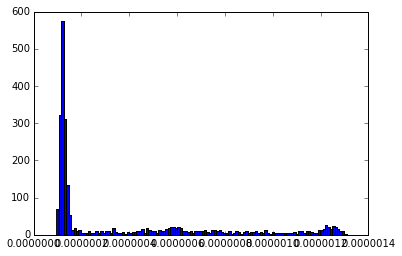

In [25]:
n, bins, patches= plt.hist(taus, bins=120)

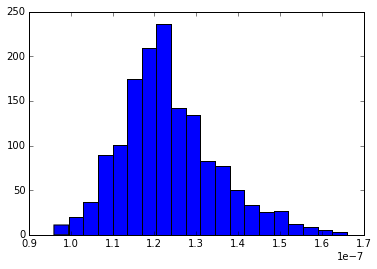

In [28]:
intermedio = np.ma.masked_greater(taus, bins[7])
primerCampana= intermedio.compressed()
n_i, bins_i, patches_i= plt.hist(primerCampana, bins=20)

In [29]:
primerCampana.size, primerCampana.mean(), errorEstandard(primerCampana)

(1478, 1.2354465493910699e-07, 4.565917976855601e-10)

###### acq150605z02: CFP-35, 2560 pulsos, $P=3.005\mathrm{\frac{kgf}{cm^2}}$ (relativa), $\mathrm{N_2/Ar}\simeq1,0\%$, TRG=$0.6\mathrm{V}$

In [30]:
acq= np.load('./data/acq150605z02.npy.npz')
taus= tauAMCz(acq)
taus.size

2560

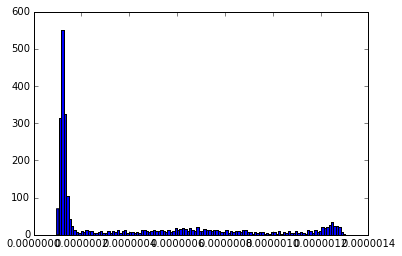

In [31]:
n, bins, patches= plt.hist(taus, bins=120)

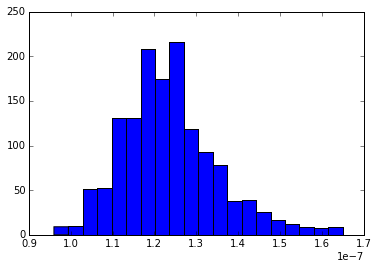

In [32]:
intermedio = np.ma.masked_greater(taus, bins[7])
primerCampana= intermedio.compressed()
n_i, bins_i, patches_i= plt.hist(primerCampana, bins=20)

In [33]:
primerCampana.size, primerCampana.mean(), errorEstandard(primerCampana)

(1429, 1.2366969909027284e-07, 2.0299730250265117e-10)

###### acq150605z03: CFP-35, 2560 pulsos, $P=3.005\mathrm{\frac{kgf}{cm^2}}$ (relativa), $\mathrm{N_2/Ar}\simeq1,0\%$, TRG=$0.6\mathrm{V}$

In [35]:
acq= np.load('./data/acq150605z03.npy.npz')
taus= tauAMCz(acq)
taus.size

2560

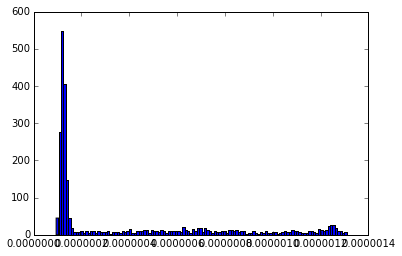

In [37]:
n, bins, patches= plt.hist(taus, bins=120)
intermedio = np.ma.masked_greater(taus, bins[7])
primerCampana= intermedio.compressed()

(1485, 1.2318451178451162e-07, 5.5001519086054805e-10)

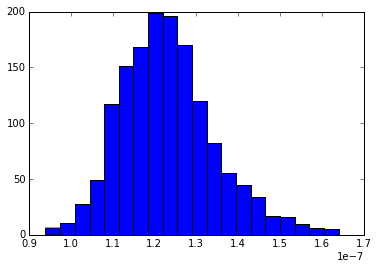

In [38]:
n_i, bins_i, patches_i= plt.hist(primerCampana, bins=20)
primerCampana.size, primerCampana.mean(), errorEstandard(primerCampana)